# Computing the core Čech filtration for a fixed $k$

In this notebook, we show how to compute the persistent homology of the core Čech filtration in the simplest case where $k$ is fixed. For $k=1$ we demonstrate that the core Čech filtration is indeed equivalent to the usual Čech filtration by comparing it to the $\alpha$-complex. Furthermore, we compute the persistent homology of a noisy circle for different values of $k$ using the core Čech filtration.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext line_profiler
# %load_ext cython

In [3]:
import math
import gudhi
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from miniball import Miniball
from scipy.spatial import KDTree

from datasets_morten import sample_circle, sample_rectangle, sample_torus, sample_cube, sample_flat_torus
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [98]:
from datasets_morten import sample_sphere

In [4]:
rng = np.random.default_rng(seed=0)

### Compute distances to k-nearest neighbors in X

In [5]:
def k_nearest_neighbor_distances(X, k):
    kd_tree = KDTree(X)
    k_core_distances, _ = kd_tree.query(X, k=k, workers=-1)
    return k_core_distances  

### Compute filtration values of faces from squared radius and core values

In [6]:
def core_value(face, squared_radius, core_values):
    max_core = max(core_values[face]) 
    return max(squared_radius ** 0.5, max_core)

### Compute core value for each points

In [7]:
def vertex_values(X, max_k, max_r):
    if max_r is None or max_k <= 1:
        return k_nearest_neighbor_distances(X, k=[max_k])
    k_core_distances = k_nearest_neighbor_distances(X, np.arange(1, max_k + 1))
    line = np.linspace(max_r, 0, num=max_k)
    if max_k>1:
        indices = np.argmax(line <= k_core_distances, axis=1)
        values = k_core_distances[np.arange(len(k_core_distances)), indices]
        values[values > max_r] = max_r
    else:
        values = np.array(k_core_distances)
    return values

### Compute core simplex tree from a simplex tree filtered by squared radius and a point cloud

In [8]:
def core_complex(X, st, max_k, max_r=None):
    k_core_distances = vertex_values(X, max_k, max_r)**2
    for vertex in range(X.shape[0]):
        st.assign_filtration([vertex], k_core_distances[vertex])
    st.make_filtration_non_decreasing()
    return st

### Compute simplex tree of a point cloud filtered by squared radius

In [9]:
def cech_squared_radius(X, max_dim=1):
    st = gudhi.SimplexTree()
    for dim in range(max_dim+1):
        for face in combinations(range(len(X)),dim+1):
            val = Miniball(X[list(face)]).squared_radius()
            st.insert(face, val)
    return st

### Construct core cech simplex tree

In [10]:
def core_cech(X, max_k=10, max_r=None, max_dim=1):
    st = cech_squared_radius(X, max_dim=max_dim)
    return core_complex(X, st, max_k, max_r)

### Construct core alpha simplex tree

In [11]:
def core_alpha(X, max_k=10, max_r=None, precision='safe'):
    st = gudhi.AlphaComplex(points=X, precision=precision).create_simplex_tree()
    return core_complex(X, st, max_k, max_r)

In [12]:
def sqrt_persistence(st):
    persistence = st.persistence()
    return [(dim, (birth**.5, death**.5)) for dim, (birth, death) in persistence]

In [13]:
def plot_sqrt_persistence(st, axes=None):
    return gudhi.plot_persistence_diagram(sqrt_persistence(st), axes=axes)

In [14]:
def persistence_intervals_in_dimension(persistence, dim):
    return np.array([(b, d) for dimension, (b, d) in persistence if dimension == dim])    

In [15]:
def persistence_diagrams(
    X, max_ks: list[int] = [1, 10, 100, 1000], 
    max_r: float | None = None
) -> list[tuple[int, tuple[int, int]]]:
    res = []
    for i, max_k in enumerate(max_ks):
        st = core_alpha(X, max_k=max_k, max_r=max_r)
        persistence = sqrt_persistence(st)
        res.append(persistence)
    return res

In [16]:
def bottleneck_distances(pers1, pers2, dim):
    n = len(pers1)
    m = len(pers2)
    A = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            a = persistence_intervals_in_dimension(pers1[i], dim)
            b = persistence_intervals_in_dimension(pers2[j], dim)
            bdist = gudhi.bottleneck_distance(a, b)
            A[i, j] = bdist
    return A

In [17]:
def plot_persistence_diagrams(pers_diagrams, max_ks, max_r, title="Alpha Čech"):
    fig, axs = plt.subplots(ncols=len(max_ks), figsize=(14, 14 / len(max_ks)))
    fig.suptitle(title)
    for i, (pers, max_k) in enumerate(zip(pers_diagrams, max_ks)):
        gudhi.plot_persistence_diagram(pers, axes=axs[i])
        # st_core = core_cech(X, max_dim=2, max_k=max_k, max_r=max_r)
        # plot_sqrt_persistence(st_core, axes=axs[i])
        # gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[i])
        axs[i].set_title(f"max_k={max_k}, max_r={max_r:.2f}")
    fig.tight_layout()
    return fig    

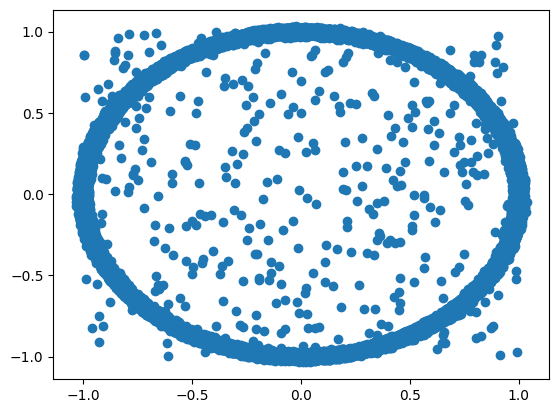

In [18]:
N = 100000
M = 400
Z = sample_circle(N, rng, std=0.01)
Y = sample_rectangle(M, rng)
X = np.r_[Z, Y]
plt.scatter(*X.T)
plt.show()

In [20]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (1, (0, 1))]]

CPU times: user 17.9 s, sys: 206 ms, total: 18.1 s
Wall time: 10.4 s


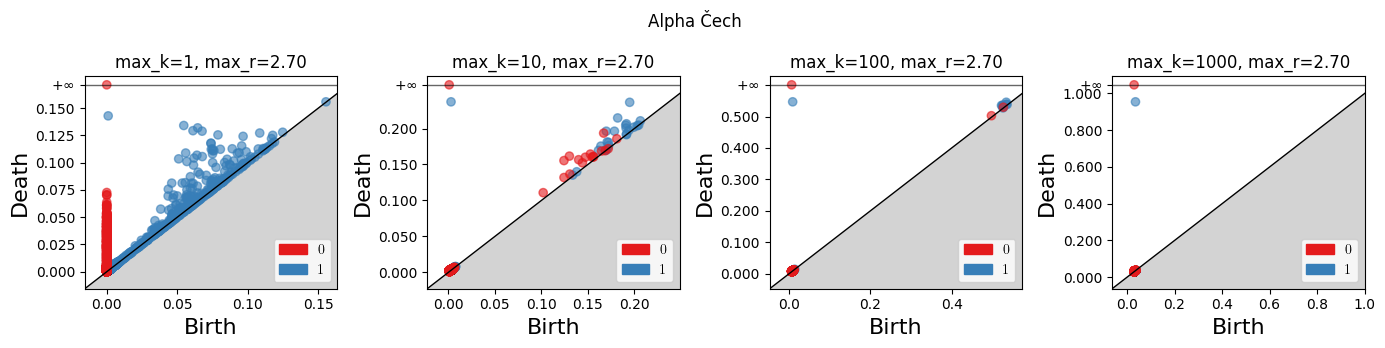

In [21]:
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [22]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

array([[0.5       , 0.5       , 0.4530759 , 0.04544689]])

In [23]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

array([[0.03633729, 0.01575303, 0.0059237 , 0.02979945]])

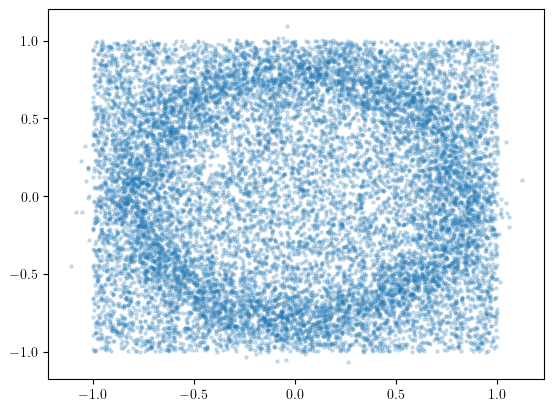

In [24]:
N = 5_000
M = 10_000
Z = sample_circle(N, rng, r=0.8, std=0.1)
Y = sample_rectangle(M, rng)
X = np.r_[Z, Y]
plt.scatter(*X.T, s=5, alpha=0.2)
plt.show()

In [25]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (1, (0, 0.6))]] 
# + pers_diagrams

CPU times: user 2.27 s, sys: 28.8 ms, total: 2.3 s
Wall time: 1.27 s


CPU times: user 440 ms, sys: 123 ms, total: 562 ms
Wall time: 1.29 s


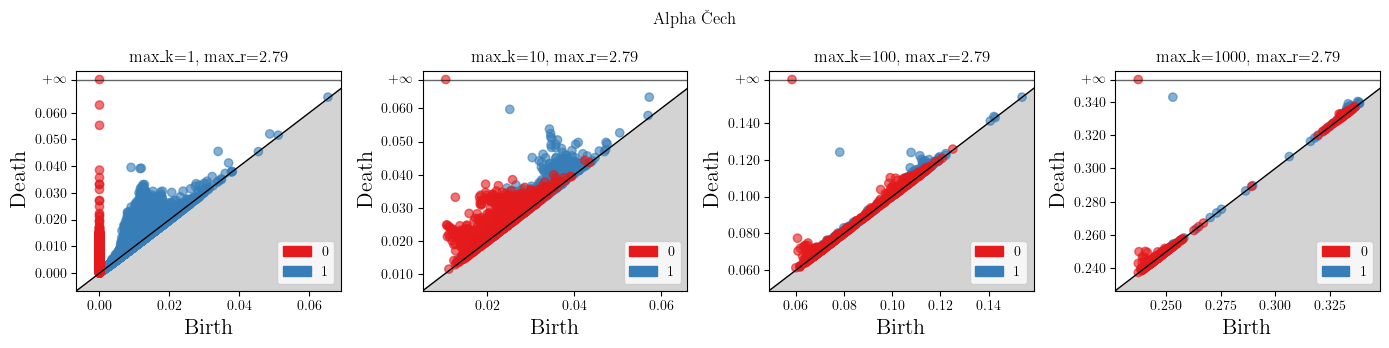

In [26]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [27]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

array([[0.3       , 0.3       , 0.3       , 0.25721951]])

In [28]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

array([[0.03144726, 0.01038146, 0.05848594, 0.23715346]])

## Three circles with noise

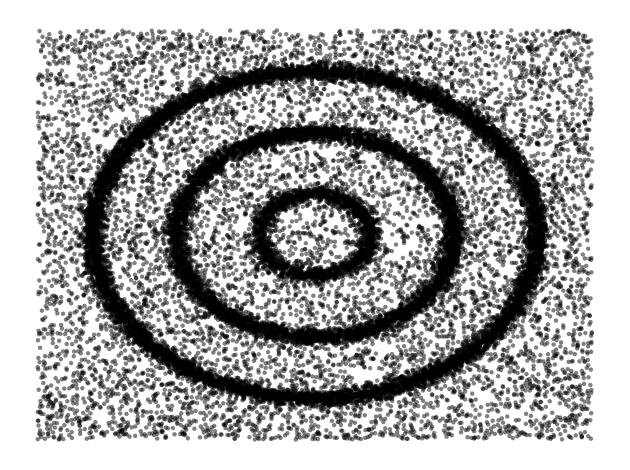

In [60]:
N1 = 10000
N2 = 6000
N3 = 2000
M = 10_000

Z1 = sample_circle(N1, rng, r=0.8, std=0.02)
Z2 = sample_circle(N2, rng, r=0.5, std=0.02)
Z3 = sample_circle(N3, rng, r=0.2, std=0.02)

Y = sample_rectangle(M, rng)
X = np.r_[Z1, Z2, Z3, Y]
plt.scatter(*X.T, s=10, color="black", alpha=0.5, edgecolor="none")
plt.gca().axis("off")
plt.tight_layout()
plt.show()

In [61]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (0, (0, 0.15)), (0, (0, 0.15)), (1, (0, 0.2)), (1, (0, 0.15)), (1, (0, 0.15))]]
# + pers_diagrams

CPU times: user 4.32 s, sys: 22.1 ms, total: 4.34 s
Wall time: 2.36 s


CPU times: user 562 ms, sys: 132 ms, total: 695 ms
Wall time: 474 ms


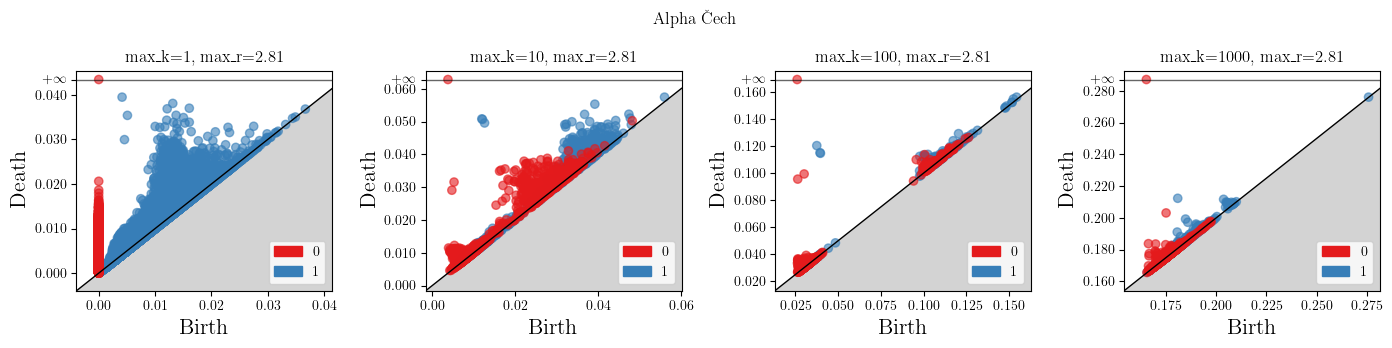

In [62]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [63]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

array([[0.1       , 0.1       , 0.07974174, 0.1       ]])

In [64]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

array([[0.075     , 0.075     , 0.05448906, 0.16520811]])

## Torus with noise

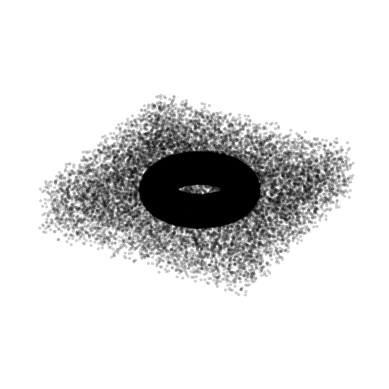

In [92]:
N = 40_000
M = 15_000

Z = sample_torus(N, rng, std=0.02)
Y = sample_cube(M, rng, lower_left_corner=(-2, -2, -0.5), upper_right_corner=(2, 2, 0.5))
X = np.r_[Z, Y]

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*X.T, alpha=0.2, color="black", s=5, edgecolor="none")
ax.set_aspect("equal")
ax.axis("off")
plt.show()

In [93]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (1, (0, 0.25)), (1, (0, 0.5)), (2, (0, 0.25))]]
# + pers_diagrams

CPU times: user 26.8 s, sys: 171 ms, total: 27 s
Wall time: 22.1 s


CPU times: user 1.44 s, sys: 202 ms, total: 1.65 s
Wall time: 2.31 s


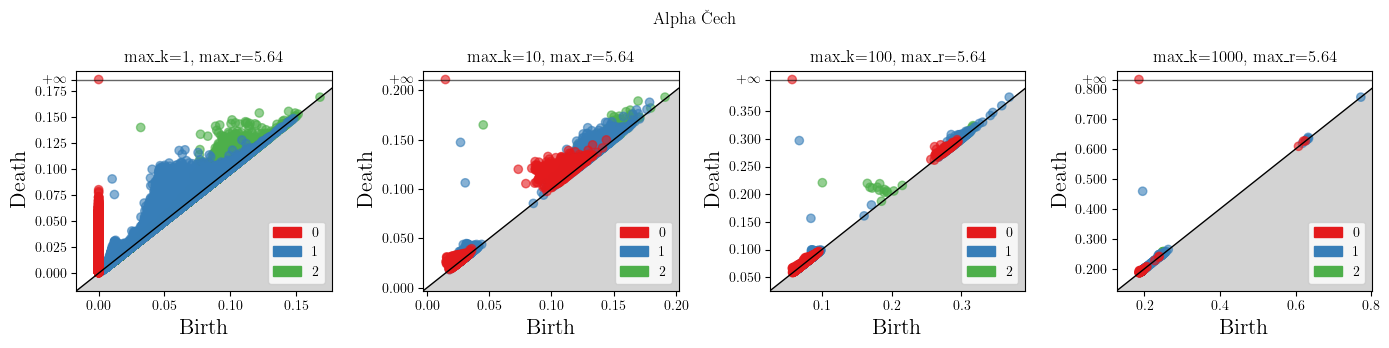

In [94]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [95]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=2)

array([[0.10298261, 0.08500742, 0.10076987, 0.125     ]])

In [96]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

array([[0.25      , 0.25      , 0.20281412, 0.19525638]])

In [97]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

array([[0.04003776, 0.02333872, 0.05750133, 0.18546589]])

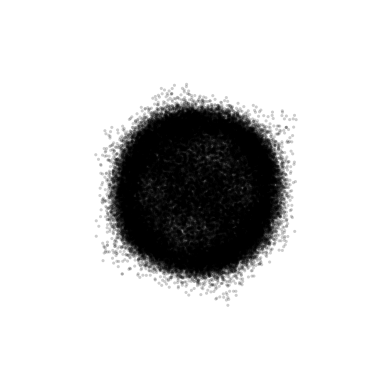

In [99]:
N = 50_000
M = 5_000

Z = sample_sphere(N, rng, std=0.1)
Y = sample_cube(M, rng, lower_left_corner=(-1, -1, -1), upper_right_corner=(1, 1, 1))
X = np.r_[Z, Y]

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*X.T, alpha=0.2, color="black", s=5, edgecolor="none")
ax.set_aspect("equal")
ax.axis("off")
plt.show()

In [100]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (2, (0, 1.))]]
# + pers_diagrams

CPU times: user 27.8 s, sys: 149 ms, total: 28 s
Wall time: 22.9 s


CPU times: user 1.63 s, sys: 170 ms, total: 1.8 s
Wall time: 2.48 s


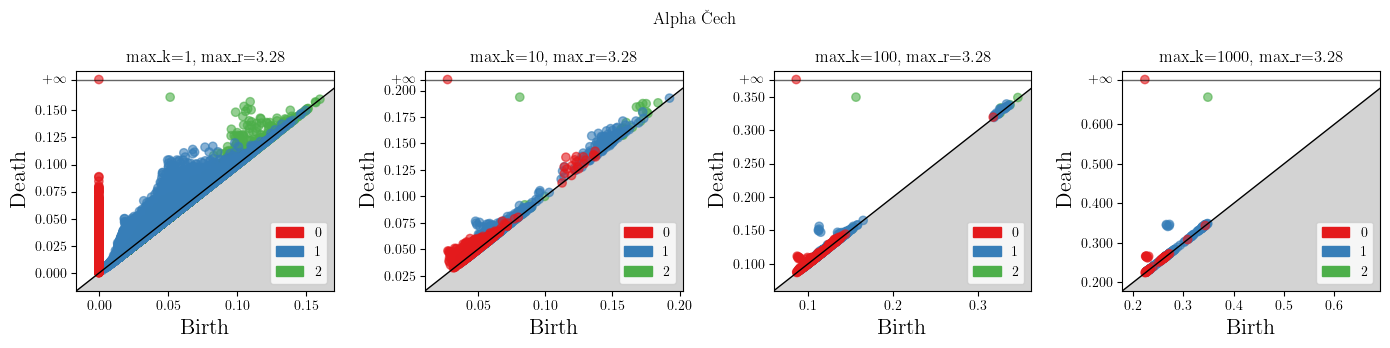

In [101]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [102]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=2)

array([[0.5       , 0.5       , 0.5       , 0.34888214]])

In [103]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

array([[0.02713946, 0.01412716, 0.02156083, 0.04003101]])

In [104]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

array([[0.04440411, 0.02748749, 0.0858872 , 0.22363039]])

In [113]:
N = 50_000
M = 5_000
Z = sample_flat_torus(N, rng, std=0.02)
Y = sample_cube(M, rng, lower_left_corner=(-1, -1, -1, -1), upper_right_corner=(1, 1, 1, 1))
X = np.r_[Z, Y]

In [114]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (1, (0, 1.)), (1, (0,1.)), (2, (0, 1.))]]
# + pers_diagrams

CPU times: user 2min 26s, sys: 717 ms, total: 2min 27s
Wall time: 2min 22s


CPU times: user 2.02 s, sys: 215 ms, total: 2.23 s
Wall time: 2.02 s


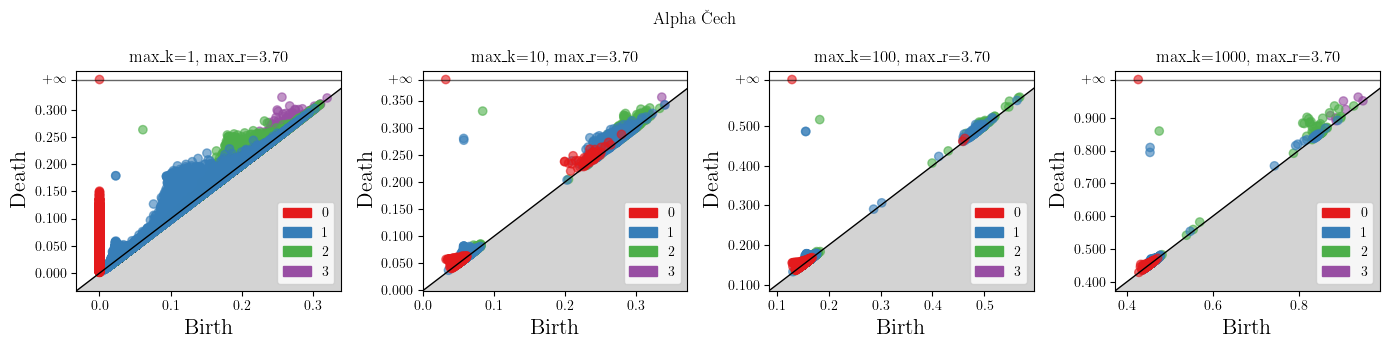

In [115]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [116]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=2)

array([[0.5       , 0.5       , 0.4836602 , 0.47537198]])

In [117]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

array([[0.5       , 0.5       , 0.49589252, 0.45409719]])

In [118]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

array([[0.07532249, 0.0317905 , 0.12934999, 0.42650239]])